In [4]:
import os
import sys
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel, cmdstan_path
import pickle
import json
from scipy.interpolate import splev
from sklearn.metrics import mean_squared_error
from aria.utils.evaluation import smape
from sklearn.preprocessing import PowerTransformer

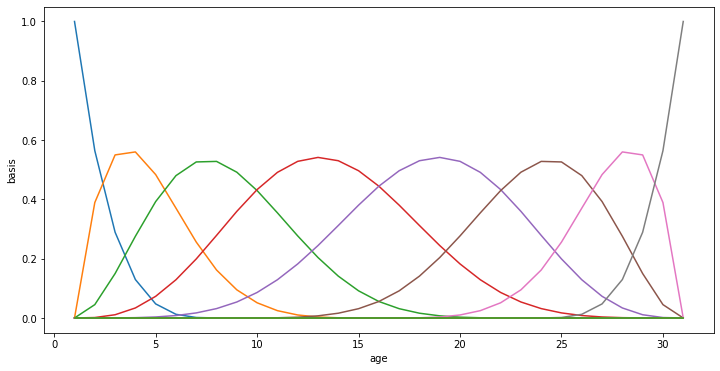

In [5]:
# knot 수에 따라 Bspline 파일 변

degree = 4
knots = np.linspace(1, 31, num=5)
knots_padded = np.concatenate((np.full(degree, 1), knots, np.full(degree, 31)))

basis = []
for i in range(knots_padded.shape[0]):
    c = np.zeros(knots_padded.shape[0])
    c[i] = 1
    basis.append(splev(np.arange(1, 32), (knots_padded, c, degree)))
basis_df = pd.DataFrame(basis).transpose().set_index(np.arange(1, 32))

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('basis')
basis_df.plot(ax=ax, legend=False)

In [6]:
transformer = PowerTransformer()
y_data_raw = pd.read_csv("../data/y_count_original.csv")
y_data_raw.drop(columns="age", inplace=True)
transformer.fit_transform(y_data_raw.values[~np.isnan(y_data_raw)].reshape(-1, 1)).flatten()

y_data = pd.read_csv(os.path.realpath("../data/y_count_pwr.csv"), usecols=["y"])
age_data = pd.read_csv(os.path.realpath("../data/x_age.csv"), usecols=["age"])
ship_data = pd.read_csv(os.path.realpath("../data/ship_index.csv"), usecols=["ship"])
ship_engine_mapping_data = pd.read_csv(os.path.realpath("../data/engine_index.csv"), usecols=["engine"])
engine_data = pd.DataFrame({"engine": np.zeros(y_data.shape[0], dtype=np.int32)})
for x in range(y_data.shape[0]):
    engine_data.at[x, "engine"] = ship_engine_mapping_data.at[ship_data.at[x, "ship"]-1, "engine"]


y_data.shape, age_data.shape, ship_data.shape, engine_data.shape, ship_engine_mapping_data.shape

((653, 1), (653, 1), (653, 1), (653, 1), (99, 1))

In [7]:
engine_count = int(np.max(engine_data["engine"]))
ship_count = int(np.max(ship_data["ship"]))
max_age = int(np.max(age_data["age"]))
data_count = int(y_data.shape[0])
engine_count, ship_count, max_age, data_count

(5, 99, 31, 653)

In [8]:
model_file = os.path.join('./stancode','layer3_nc_diffsd_parammubar.stan')
layer3_model = CmdStanModel(stan_file=model_file) #compile_model(layer3_path)

INFO:cmdstanpy:compiling stan program, exe file: /home/dashadower/git_repos/aria/regression/failure_bma/spline/stancode/layer3_nc_diffsd_parammubar
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/spline/stancode/layer3_nc_diffsd_parammubar


In [9]:
data = {
    "K" : basis_df.shape[1],
    "N" : data_count,  # number of total values
    "T" : max_age,  # length of time of data(31)
    "S" : ship_count, #failure_df.shape[1],  # number of ships(99)
    "E" : engine_count,  # number of unique engines
    "age": age_data["age"].values.tolist(),
    "engine": ship_engine_mapping_data["engine"].values.tolist(),  # engine type mapping
    "ship": ship_data["ship"].values.tolist(),#[int(i) for i in np.where(~np.isnan(failure_df).transpose())[0] + 1],  # ship type mapping
    "Y": y_data["y"].values.tolist(),#failure_df.values[~np.isnan(failure_df)].tolist(),  # all values to list
    "B": basis_df.values.tolist(),  # spline values, 2d list
    "N_hat": data_count,
    "age_hat": age_data["age"].values.tolist(),
    "ship_hat": ship_data["ship"].values.tolist(),
}

In [ ]:
layer3_fit = layer3_model.sample(chains=4, cores=4, data=data, adapt_delta=0.8)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4


In [ ]:
layer3_fit.diagnose()

In [ ]:
layer3_fit.summary()

In [ ]:
yhat = np.mean(layer3_fit.get_drawset(params=["y_hat"]), axis=0).values
yhat.shape

In [ ]:
lambda_ = np.array([0.21649144])
mean_ = np.array([4.96401329])
var_ = np.array([5.32670014])
scale_ = np.array([2.3079645])
n_samples_seen_ = 653
yhat = transformer.inverse_transform(yhat.reshape(-1, 1)).flatten()

In [ ]:
mean_squared_error(yhat, y_data["y"].values.flatten())

In [ ]:
layer3_fit.get_drawset(params=["y_hat"])

In [ ]:
smape(yhat, y_data["y"].values.flatten())

In [ ]:
transformer.inverse_transform(y_data["y"].values.reshape(-1, 1)).flatten()

In [ ]:
yhat